In [1]:
import os
import importlib

from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient

from llama_index.core.schema import  MetadataMode
from llama_index.core.settings import Settings
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.vector_stores.azureaisearch import MetadataIndexFieldType
from llama_index.multi_modal_llms.azure_openai import AzureOpenAIMultiModal
from llama_index.core.response.notebook_utils import display_query_and_multimodal_response
from llama_index.core.vector_stores.types import VectorStoreQueryMode
from llama_parse import LlamaParse

from dotenv import load_dotenv
load_dotenv(override=True)

import src.tools as tools
importlib.reload(tools)
from src.tools import get_images_from_pdf, upload_images_to_blob_storage, get_text_nodes, MultimodalQueryEngine, create_or_load_index

In [2]:
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME")
azure_openai_endpoint = f"{AZURE_OPENAI_ENDPOINT}/openai/deployments/{AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME}/chat/completions?api-version=2024-08-01-preview"
AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME")
SEARCH_SERVICE_ENDPOINT = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
SEARCH_SERVICE_API_KEY = os.getenv("AZURE_SEARCH_ADMIN_KEY")

In [ ]:
# pdf_path = "data/llamaparse/financial_report.pdf"
# images_path = "images/financial_report_2024"
# BLOB_CONTAINER_NAME = "ignite-demo-images-01"

BASE_DIR = "data/llamaparse"
IMAGES_DIR = "images"
BLOB_CONTAINER_PREFIX = "rag-storage"
CONCURRENT_UPLOADS = 5
similarity_top_k = 3

In [4]:

# Initialize LLM and Embedding models
llm = AzureOpenAI(
    model=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-08-01-preview"
)

llm_light_task = AzureOpenAI(
    model='gpt-4o-mini',
    deployment_name='gpt-4o-mini',
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-08-01-preview"
)

azure_openai_mm_llm = AzureOpenAIMultiModal(
    engine=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_version="2024-08-01-preview",
    model=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    max_new_tokens=4096,
    api_key=AZURE_OPENAI_API_KEY,
    api_base=AZURE_OPENAI_ENDPOINT,
)

embed_model = AzureOpenAIEmbedding(
    model=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-08-01-preview"
)

parser = LlamaParse(
    result_type="markdown",
    use_vendor_multimodal_model=True,
    azure_openai_deployment_name=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    azure_openai_endpoint=azure_openai_endpoint,
    azure_openai_api_version="2024-08-01-preview",
    azure_openai_key=AZURE_OPENAI_API_KEY,
)

Settings.llm = llm
Settings.embed_model = embed_model

In [5]:
# Initialize search clients
credential = AzureKeyCredential(SEARCH_SERVICE_API_KEY)
index_client = SearchIndexClient(endpoint=SEARCH_SERVICE_ENDPOINT, credential=credential)

# Define metadata fields mapping
metadata_fields = {
    "page_num": ("page_num", MetadataIndexFieldType.INT64),
    "image_path": ("image_path", MetadataIndexFieldType.STRING),
    "parsed_text_markdown": ("parsed_text_markdown", MetadataIndexFieldType.STRING),
}

In [ ]:
# Get all files in the BASE_DIR
files = os.listdir(BASE_DIR)

# Loop through each file in the directory
for idx, file_name in enumerate(files):
    if file_name.endswith(".pdf"):  # Process only PDF files
        pdf_path = os.path.join(BASE_DIR, file_name)
        images_path = os.path.join(IMAGES_DIR, file_name.replace(".pdf", ""))
        BLOB_CONTAINER_NAME = f"{BLOB_CONTAINER_PREFIX}-{idx:02}"  # Add unique identifier to the container name

        # Print or process the paths and container name
        print(f"PDF Path: {pdf_path}")
        print(f"Images Path: {images_path}")
        print(f"Blob Container Name: {BLOB_CONTAINER_NAME}")

        md_json_objs, md_json_list, image_dicts = get_images_from_pdf(pdf_path, images_path, parser)

        image_urls = upload_images_to_blob_storage(BLOB_CONTAINER_NAME, CONCURRENT_UPLOADS, image_dicts)

        # Create text nodes
        text_nodes = get_text_nodes(image_urls=image_urls, json_dicts=md_json_list)

        # Print an example node to verify
        # print(text_nodes[0].get_content(metadata_mode=MetadataMode.ALL))

        # Initialize the dictionary
        document_summary_dict = {}

        document_content = " ".join(node.get_content() for node in text_nodes)
        summary = llm_light_task.complete(f"summarize this text: {document_content}").text
        INDEX_NAME = llm_light_task.complete(f"define a single name for this document based on this summary: {summary}. An example would be like this: llamaindex-azure-aisearch-rag. Make sure it is one single word or multiple words connected with '-'.").text
        INDEX_NAME = f"index_{INDEX_NAME.replace('-', '_')}"

        # Add to dictionary
        document_summary_dict[INDEX_NAME] = summary

        # Print the dictionary
        print(document_summary_dict)

        search_client = SearchClient(endpoint=SEARCH_SERVICE_ENDPOINT, index_name=INDEX_NAME, credential=credential)

        # Store the index in a dictionary
        indexes = {}
        indexes[INDEX_NAME] = create_or_load_index(
            text_nodes=text_nodes,
            index_client=index_client,
            index_name=INDEX_NAME,
            embed_model=embed_model,
            llm=llm,
            metadata_fields=metadata_fields,
            use_existing_index=False
        )
        print("===============================================")

PDF Path: data/llamaparse\financial_report.pdf
Images Path: images\financial_report
Blob Container Name: rag-storage-00
Started parsing the file under job_id 3bea0972-468a-4770-9c16-51eaee179f33
> Image for page 1: [{'name': 'page_1.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 2: [{'name': 'page_2.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 3: [{'name': 'page_3.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 4: [{'name': 'page_4.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 5: [{'name': 'page_5.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 6: [{'name': 'page_6.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 7: [{'name': 'page_7.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'ful

Generating embeddings: 100%|██████████| 35/35 [00:01<00:00, 30.68it/s]


PDF Path: data/llamaparse\Gen_AI_Report_Databricks.pdf
Images Path: images\Gen_AI_Report_Databricks
Blob Container Name: rag-storage-01
Started parsing the file under job_id f118a84b-0523-42e3-bef6-a613faf47f13
> Image for page 1: [{'name': 'page_1.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 2: [{'name': 'page_2.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 3: [{'name': 'page_3.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 4: [{'name': 'page_4.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 5: [{'name': 'page_5.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 6: [{'name': 'page_6.jpg', 'height': 0, 'width': 0, 'x': 0, 'y': 0, 'type': 'full_page_screenshot'}]
> Image for page 7: [{'name': 'page_7.jpg', 'height': 0, 'width': 0, 'x': 0, 'y':

Generating embeddings: 100%|██████████| 24/24 [00:01<00:00, 19.51it/s]


In [16]:
print(text_nodes[1].get_content(metadata_mode=MetadataMode.ALL))

page_num: 2
image_path: https://stragdemopro253585616804.blob.core.windows.net/rag-storage-01/page_2.jpg
parsed_text_markdown: # Preface

“The great acceleration: CIO perspectives on generative AI” is an MIT Technology Review Insights report sponsored by Databricks. This report, based on seven in-depth interviews with senior executives and experts, conducted in April and May 2023, seeks to understand how technology leaders are adopting emerging generative AI tools as part of an enterprise-wide AI strategy. The report also draws on an MIT Technology Review Insights global survey of 600 senior data and technology executives, conducted in May and June 2022. Adam Green was the author of the report, Teresa Esley was the editor, and Nico Crepaldi was the publisher. The research is editorially independent and the views expressed are those of MIT Technology Review Insights.

We would like to thank the following individuals for their time and insights:

**Andrew Blyton**, Vice President and Chi

In [ ]:
# md_json_objs, md_json_list, image_dicts = get_images_from_pdf(pdf_path, images_path, parser)

In [ ]:
# image_urls = upload_images_to_blob_storage(BLOB_CONTAINER_NAME, CONCURRENT_UPLOADS, image_dicts)

In [ ]:
# # Create text nodes
# text_nodes = get_text_nodes(image_urls=image_urls, json_dicts=md_json_list)

# # Print an example node to verify
# print(text_nodes[0].get_content(metadata_mode=MetadataMode.ALL))

In [ ]:
# # Initialize the dictionary
# document_summary_dict = {}

# document_content = " ".join(node.get_content() for node in text_nodes)
# summary = llm_light_task.complete(f"summarize this text: {document_content}").text
# INDEX_NAME = llm_light_task.complete(f"define a single name for this document based on this summary: {summary}. An example would be like this: llamaindex-azure-aisearch-rag. Make sure it is one single word or multiple words connected with '-'.").text

# # Add to dictionary
# document_summary_dict[INDEX_NAME] = summary

# # Print the dictionary
# print(document_summary_dict)

In [ ]:
# # Initialize search clients
# credential = AzureKeyCredential(SEARCH_SERVICE_API_KEY)
# index_client = SearchIndexClient(endpoint=SEARCH_SERVICE_ENDPOINT, credential=credential)
# search_client = SearchClient(endpoint=SEARCH_SERVICE_ENDPOINT, index_name=INDEX_NAME, credential=credential)

# # Define metadata fields mapping
# metadata_fields = {
#     "page_num": ("page_num", MetadataIndexFieldType.INT64),
#     "image_path": ("image_path", MetadataIndexFieldType.STRING),
#     "parsed_text_markdown": ("parsed_text_markdown", MetadataIndexFieldType.STRING),
# }

In [ ]:
# index_variable_name = f"index_{INDEX_NAME.replace('-', '_')}"

# # Store the index in a dictionary
# indexes = {}
# indexes[index_variable_name] = create_or_load_index(
#     text_nodes=text_nodes,
#     index_client=index_client,
#     index_name=INDEX_NAME,
#     embed_model=embed_model,
#     llm=llm,
#     metadata_fields=metadata_fields,
#     use_existing_index=False
# )

In [12]:

query = "Which figure illustrates the applications of GenAI?"

# Generate the prompt dynamically based on the query and document summaries
prompt = (
    f"Given the query '{query}', determine the most appropriate index (key) in the dictionary "
    f"based on the description (value) that corresponds best to the query. "
    f"Return only the index (key) as the output, nothing else. "
    f"Options: {', '.join([f'Index: {key}, Description: {value}' for key, value in document_summary_dict.items()])}"
)

# Call the LLM endpoint with the prompt
selected_index = llm.complete(prompt).text.strip()

print(selected_index)

index = indexes[selected_index]

index_great_acceleration_generative_ai


In [13]:
# Create and initialize the query engine
query_engine = MultimodalQueryEngine(
    retriever=index.as_retriever(
        vector_store_query_mode=VectorStoreQueryMode.DEFAULT, similarity_top_k=similarity_top_k 
    ),
    multi_modal_llm=azure_openai_mm_llm,
)

Query: Which figure illustrates the applications of GenAI?
Retrieved Images:



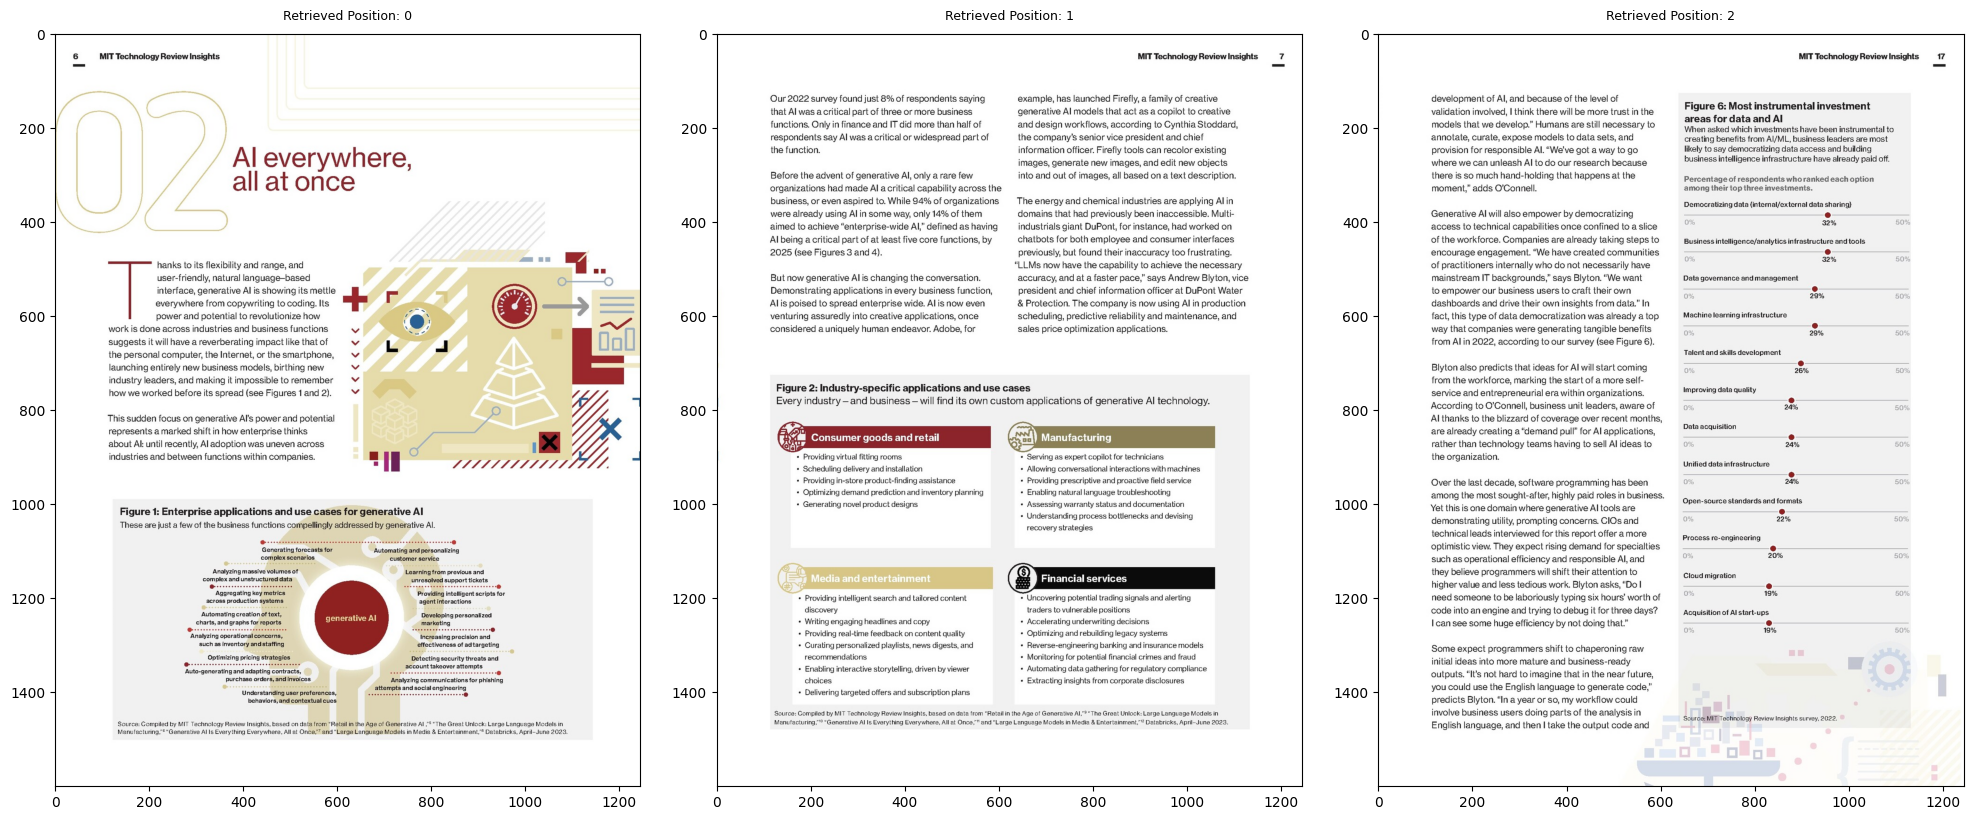

Response: The figure that illustrates the applications of generative AI is Figure 1. This is evident from the parsed markdown text on page 6, which includes a table under the heading "Figure 1: Enterprise applications and use cases for generative AI." The table lists various business functions that generative AI can address.

Here is the relevant excerpt from the parsed markdown:

```
## Figure 1: Enterprise applications and use cases for generative AI
These are just a few of the business functions compellingly addressed by generative AI.

| Generative AI Applications |
|----------------------------|
| Generating forecasts for complex scenarios |
| Analyzing massive volumes of complex and unstructured data |
| Aggregating key metrics across production systems |
| Automating creation of text, charts, and graphs for reports |
| Analyzing operational concerns, such as inventory and staffing |
| Optimizing pricing strategies |
| Auto-generating and adapting contracts, purchase orders, and 

In [14]:
# Execute the query
response = query_engine.query(query)

# Display the query and multimodal response
display_query_and_multimodal_response(query, response, 8, 20)

# Print source nodes for transparency
print("\nSource Nodes:")
for node in response.source_nodes:
    print("\nPage Number:", node.metadata["page_num"])
    print("Text Content Length:", len(node.text))